In [1]:

import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder


#train and test data directory
data_dir = "gym/final data/Train/Train"
test_data_dir = "gym/final data/Test/Test"


#load the train and test data
dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
# %pip install split_folders

In [4]:
img, label = dataset[0]
print(img.shape,label)

torch.Size([3, 150, 150]) 0


In [5]:
print("Follwing classes are there : \n",dataset.classes)

Follwing classes are there : 
 ['Dumbells', 'elliptical', 'home', 'recum']


In [6]:
import matplotlib.pyplot as plt

Label : Dumbells


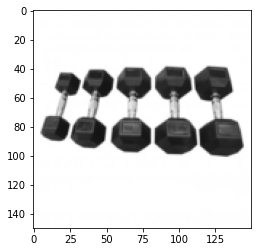

In [7]:
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*dataset[0])

In [24]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 256
val_size = 100
train_size = len(dataset) - val_size 

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

#output
#Length of Train Data : 12034
#Length of Validation Data : 2000

#load the train and validation into batches.
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)


Length of Train Data : 535
Length of Validation Data : 100


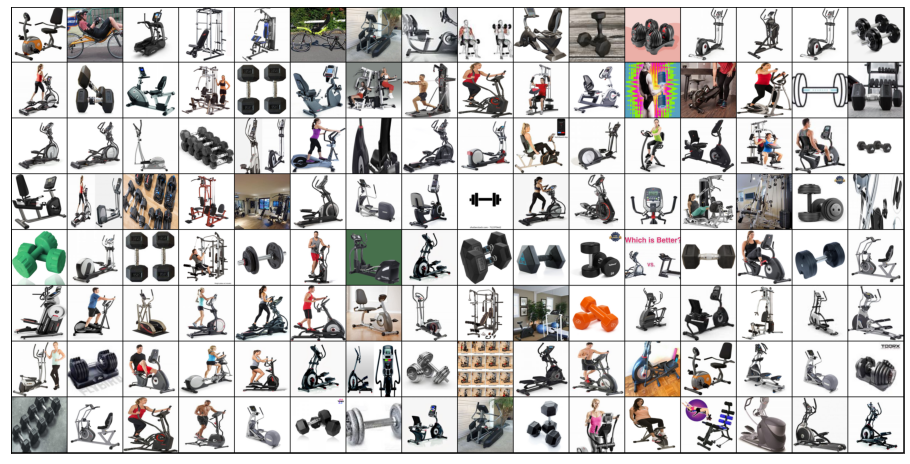

In [9]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)


### 

In [25]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=6):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)
        
        
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)
        
        
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=4)
        
        
        
        #Feed forwad function
        def forward(self,input):
            output=self.conv1(input)
            output=self.bn1(output)
            output=self.relu1(output)

            output=self.pool(output)

            output=self.conv2(output)
            output=self.relu2(output)

            output=self.conv3(output)
            output=self.bn3(output)
            output=self.relu3(output)
            
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
            output=output.view(-1,32*75*75)


            output=self.fc(output)
            
            return output
            

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [19]:
class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 32),
            nn.ReLU(),
            nn.Linear(32,4)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [21]:
model0 = NaturalSceneClassification()

In [22]:
fit(epochs=5, lr=0.01, model=model0,train_loader=train_dl, val_loader=val_dl)

Epoch [0], train_loss: 1.4107, val_loss: 1.4135, val_acc: 0.1300
Epoch [1], train_loss: 1.4077, val_loss: 1.4100, val_acc: 0.1300
Epoch [2], train_loss: 1.4034, val_loss: 1.4065, val_acc: 0.1300
Epoch [3], train_loss: 1.3999, val_loss: 1.4033, val_acc: 0.1300
Epoch [4], train_loss: 1.3979, val_loss: 1.4000, val_acc: 0.1300


[{'val_loss': 1.4134953022003174,
  'val_acc': 0.12999999523162842,
  'train_loss': 1.4106547832489014},
 {'val_loss': 1.4099558591842651,
  'val_acc': 0.12999999523162842,
  'train_loss': 1.4076942205429077},
 {'val_loss': 1.4065171480178833,
  'val_acc': 0.12999999523162842,
  'train_loss': 1.4033820629119873},
 {'val_loss': 1.4032634496688843,
  'val_acc': 0.12999999523162842,
  'train_loss': 1.399908423423767},
 {'val_loss': 1.40004301071167,
  'val_acc': 0.12999999523162842,
  'train_loss': 1.3978685140609741}]